<img src="Fotos/Img1.jpg" alt="Drawing" style="width:750px;"/>

# Previsão de preço de imóveis na cidade de Ames, Iowa-USA

Ames é uma cidade localizada no estado americano de Iowa, no Condado de Story.<br>Segundo o censo americano de 2017, a sua população é de 66.498 habitantes. Uma cidade de médio/pequeno porte localizada próximo ao centro do país.<br>
Utilizando um dataset disponibilizado pelo site [kaggle](https://www.kaggle.com/), este projeto irá criar um algoritmo utilizando aprendizado de máquina para prever preços de imóveis nessa cidade.


In [1]:
#Bibliotecas necessarias no projeto:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Dataset:

O dataset que será usado é chamado de train.csv e se encontra na pasta "Dados" deste repositório e foi disponibilizado no kaggle para competição [aqui](https://www.kaggle.com/c/iowa-house-price-prediction/data)

In [2]:
dataset_nome_arquivo = "Dados/train.csv"
imoveis_dataset = pd.read_csv(dataset_nome_arquivo) 

In [3]:
imoveis_dataset.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Inicialmente será separado o preço em <b>Y</b>, pois será nosso valor a ser estimado:

In [4]:
y = imoveis_dataset["SalePrice"]

No entanto a tabela nos fornece diversas informações sobre os imóveis das quais não necessitamos:

In [5]:
imoveis_dataset.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Então selecionamos as que possuem maior impacto no preco do imovel:
* Área do lote: 'LotArea'
* Ano de construção: 'YearBuilt'
* Tamanho do primeiro andar: '1stFlrSF'
* Tamanho do segundo andar: '2ndFlrSF'
* Quantos banheiros: 'FullBath' 
* Número de quartos (sem contar com os que estão no porão): 'BedroomAbvGr'
* Número de cômodos (sem contar com os que estão no porão) 'TotRmsAbvGrd'
* Área de garagem: 'GarageArea'

E as passamos para a variável X:

In [6]:
especificacoes_importantes = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageArea']
X = imoveis_dataset[especificacoes_importantes]

#### Separação dos dados para o treino e para a validação:

In [7]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Comparando modelos:

Serão comparados os resultados de decisão dos modelos de DecisionTree e RandomForest, o critério será o erro médio absoluto diante dos dados separados para a previsão.

### Random Forest

In [8]:
forest_model = RandomForestRegressor(random_state=1)

In [9]:
forest_model.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

#### Calculando erro médio absoluto

In [10]:
melb_preds = forest_model.predict(val_X)
print("O erro médio absoluto do modelo Random Forest é: ", round(mean_absolute_error(val_y, melb_preds), 2), "dólares.")

O erro médio absoluto do modelo Random Forest é:  23459.33 dólares.


## Decision Tree

No caso da árvore de decisão será construído uma função para ajudar determinar um número de folhas ideal para evitar underfiting e overfiting, através da busca pelo parâmetro com menor erro médio absoluto:

In [11]:
#Primeiro uma funcao que retorna o erro medio absoluto
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [12]:
mae_list = []
lista_numero_folhas = list(range(2, len(train_X)))
for i in lista_numero_folhas:
    mae_list.append(get_mae(i, train_X, val_X, train_y, val_y))    

#### Gráfico para visualização do número ideal de folhas para o modelo

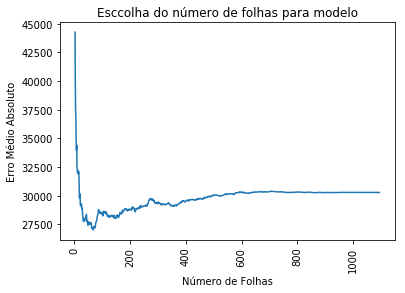

In [13]:
plt.plot(lista_numero_folhas, mae_list)
plt.xticks(rotation = 90)
plt.xlabel("Número de Folhas")
plt.ylabel("Erro Médio Absoluto")
plt.title('Esccolha do número de folhas para modelo')
plt.show()

In [14]:
print("O erro médio absoluto do modelo Decision Tree é: ", round(min(mae_list), 2), "dólares.")

O erro médio absoluto do modelo Decision Tree é:  27036.42 dólares.


# Conclusão

Mesmo otimizando o número de folhas para o modelo de árvore de decisão o erro médio absoluto de 27036,42 dólares foir maior que o do modelo de Random Forest, com o erro de apenas 23459,33 dólares. Portanto o melhor modelo treinado para a previsão do preço de imóveis em Ames foi Random Forest.